In [1]:
# 📦 Imports
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.metrics import accuracy_score


In [2]:
# ⚙️ Config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu"  # For testing purposes, use CPU
BATCH_SIZE = 32
EPOCHS = 50
HIDDEN_DIM = 32

In [3]:
device 

device(type='cuda')

In [4]:
# 📄 Load Data
df = pd.read_csv("data/allHorizonData_cut.csv")

# 🧹 Build Sequences and Labels
seq_inputs, static_inputs, labels, horizons = [], [], [], []

for _, row in df.iterrows():
    rewards = [row[f"r{i}"] for i in range(1, 5)]
    choices = [row[f"c{i}"] for i in range(1, 5)]
    seq = list(zip(rewards, choices))  # [4, 2]

    static = [row["gameLength"], row["uc"]]
    label = row["c5"]-1

    seq_inputs.append(seq)
    static_inputs.append(static)
    labels.append(label)
    horizons.append(row["gameLength"])

# Convert to torch tensors
seq_tensor = torch.tensor(seq_inputs).float()
static_tensor = torch.tensor(static_inputs).float()
label_tensor = torch.tensor(labels).float()
horizon_tensor = torch.tensor(horizons).int()


In [5]:
# 🧪 Train/Test Split
dataset = TensorDataset(seq_tensor, static_tensor, label_tensor, horizon_tensor)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_data, val_data = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE)

In [6]:
class HorizonLSTM_MultiHead(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=32):
        super(HorizonLSTM_MultiHead, self).__init__()

        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, batch_first=True)

        self.shared_fc = nn.Sequential(
            nn.Linear(hidden_dim + 2, 32),
            nn.ReLU()
        )

        # 🧠 Heads (all optional meanings for now)
        self.choice_head = nn.Sequential(
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

        self.extra1_head = nn.Linear(32, 1)   # maybe alpha later
        self.extra2_head = nn.Linear(32, 1)   # maybe sigma later

    def forward(self, seq_input, static_input):
        lstm_out, _ = self.lstm(seq_input)
        last_hidden = lstm_out[:, -1, :]
        combined = torch.cat((last_hidden, static_input), dim=1)

        base = self.shared_fc(combined)

        choice_prob = self.choice_head(base).squeeze(1)  # [batch]
        extra1 = self.extra1_head(base).squeeze(1)       # [batch]
        extra2 = self.extra2_head(base).squeeze(1)       # [batch]

        return choice_prob, extra1, extra2


In [7]:
# 🏋️ Train
model = HorizonLSTM_MultiHead().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

for epoch in range(EPOCHS):
    model.train()
    epoch_preds = []
    epoch_labels = []
    total_loss = 0
    latent1_vals = []
    latent2_vals = []

    for seq_batch, static_batch, label_batch, _ in train_loader:
        seq_batch = seq_batch.to(device)
        static_batch = static_batch.to(device)
        label_batch = label_batch.to(device)

        optimizer.zero_grad()

        # ⬇️ unpack 3 heads
        choice_probs, extra1, extra2 = model(seq_batch, static_batch)
        loss = criterion(choice_probs, label_batch)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # 👇 Convert predictions to 0 or 1
        preds = (choice_probs > 0.5).int()
        epoch_preds.extend(preds.cpu().numpy())
        epoch_labels.extend(label_batch.cpu().numpy())

        # Collect latent values for logging
        latent1_vals.extend(extra1.detach().cpu().numpy())
        latent2_vals.extend(extra2.detach().cpu().numpy())

    if epoch % 5 == 0:
        correct = np.sum(np.array(epoch_preds) == np.array(epoch_labels))
        acc = correct / len(epoch_preds)
        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch}: Loss = {avg_loss:.4f}, Accuracy = {acc:.4f}, "
              f"Latent1 mean: {np.mean(latent1_vals):.4f}, Latent2 mean: {np.mean(latent2_vals):.4f}")




Epoch 0: Loss = 0.6828, Accuracy = 0.5424, Latent1 mean: -0.3832, Latent2 mean: -0.1446
Epoch 5: Loss = 0.5198, Accuracy = 0.7568, Latent1 mean: -0.4160, Latent2 mean: -0.1158
Epoch 10: Loss = 0.4987, Accuracy = 0.7731, Latent1 mean: -0.4336, Latent2 mean: -0.1404
Epoch 15: Loss = 0.4926, Accuracy = 0.7777, Latent1 mean: -0.4313, Latent2 mean: -0.1655
Epoch 20: Loss = 0.4851, Accuracy = 0.7809, Latent1 mean: -0.4370, Latent2 mean: -0.1686
Epoch 25: Loss = 0.4790, Accuracy = 0.7848, Latent1 mean: -0.4156, Latent2 mean: -0.1627
Epoch 30: Loss = 0.4814, Accuracy = 0.7816, Latent1 mean: -0.3855, Latent2 mean: -0.1372
Epoch 35: Loss = 0.4779, Accuracy = 0.7873, Latent1 mean: -0.3546, Latent2 mean: -0.1223
Epoch 40: Loss = 0.4751, Accuracy = 0.7867, Latent1 mean: -0.2467, Latent2 mean: -0.1618
Epoch 45: Loss = 0.4714, Accuracy = 0.7890, Latent1 mean: -0.1890, Latent2 mean: -0.1139


In [9]:
# 📈 Evaluate
model.eval()
all_preds, all_labels, all_horizons = [], [], []
all_latent1, all_latent2 = [], []

with torch.no_grad():
    for seq_batch, static_batch, label_batch, horizon_batch in val_loader:
        seq_batch = seq_batch.to(device)
        static_batch = static_batch.to(device)

        # ⬇️ Unpack all 3 heads
        choice_probs, latent1, latent2 = model(seq_batch, static_batch)

        # Squeeze and move to CPU for accuracy
        preds = choice_probs.squeeze().cpu().numpy()
        bin_preds = (preds > 0.5).astype(int)

        all_preds.extend(bin_preds)
        all_labels.extend(label_batch.numpy())
        all_horizons.extend(horizon_batch.numpy())

        # ⬇️ Track latent variables for analysis
        all_latent1.extend(latent1.cpu().numpy())
        all_latent2.extend(latent2.cpu().numpy())



In [10]:

# 🎯 Overall Accuracy
overall_acc = accuracy_score(all_labels, all_preds)
print(f"\nOverall Accuracy: {overall_acc:.4f}")



Overall Accuracy: 0.7737


In [11]:

# 📊 Horizon-wise Accuracy
h1_acc = accuracy_score(
    [l for l, h in zip(all_labels, all_horizons) if h == 5],
    [p for p, h in zip(all_preds, all_horizons) if h == 5]
)
h6_acc = accuracy_score(
    [l for l, h in zip(all_labels, all_horizons) if h == 10],
    [p for p, h in zip(all_preds, all_horizons) if h == 10]
)

print(f"Horizon 1 Accuracy: {h1_acc:.4f}")
print(f"Horizon 6 Accuracy: {h6_acc:.4f}")

Horizon 1 Accuracy: 0.8348
Horizon 6 Accuracy: 0.7119


In [12]:
lat1 = np.array(all_latent1)
lat2 = np.array(all_latent2)
horizons = np.array(all_horizons)

lat1_H1 = lat1[horizons == 5]
lat1_H6 = lat1[horizons == 10]

lat2_H1 = lat2[horizons == 5]
lat2_H6 = lat2[horizons == 10]

print(f"Latent1 mean H1: {lat1_H1.mean():.4f} | H6: {lat1_H6.mean():.4f}")
print(f"Latent2 mean H1: {lat2_H1.mean():.4f} | H6: {lat2_H6.mean():.4f}")

Latent1 mean H1: -0.1597 | H6: -0.1927
Latent2 mean H1: -0.0911 | H6: -0.1019


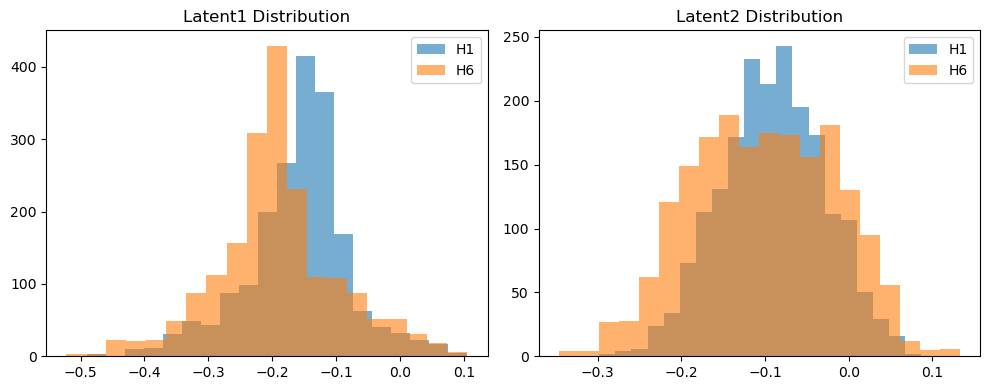

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.hist(lat1_H1, bins=20, alpha=0.6, label="H1")
plt.hist(lat1_H6, bins=20, alpha=0.6, label="H6")
plt.title("Latent1 Distribution")
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(lat2_H1, bins=20, alpha=0.6, label="H1")
plt.hist(lat2_H6, bins=20, alpha=0.6, label="H6")
plt.title("Latent2 Distribution")
plt.legend()

plt.tight_layout()
plt.show()


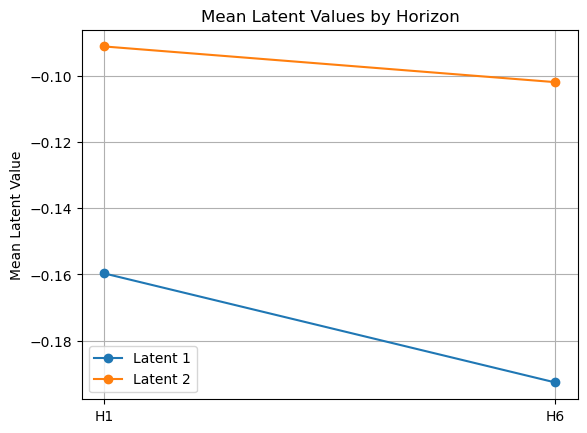

In [17]:
horizons_labels = ["H1", "H6"]
latent1_means = [lat1_H1.mean(), lat1_H6.mean()]
latent2_means = [lat2_H1.mean(), lat2_H6.mean()]

plt.plot(horizons_labels, latent1_means, marker='o', label="Latent 1")
plt.plot(horizons_labels, latent2_means, marker='o', label="Latent 2")
plt.title("Mean Latent Values by Horizon")
plt.ylabel("Mean Latent Value")
plt.legend()
plt.grid(True)
plt.show()


In [18]:
from scipy.stats import ttest_ind

t_lat1 = ttest_ind(lat1_H1, lat1_H6)
t_lat2 = ttest_ind(lat2_H1, lat2_H6)

print("Latent1 t-test:", t_lat1)
print("Latent2 t-test:", t_lat2)


Latent1 t-test: TtestResult(statistic=np.float64(11.497734942539772), pvalue=np.float64(4.191213010610329e-30), df=np.float32(3838.0))
Latent2 t-test: TtestResult(statistic=np.float64(4.504342790425753), pvalue=np.float64(6.855893897814654e-06), df=np.float32(3838.0))
